# CHX Image Classification
## Feature Extraction and Fine-Tuning

In this exercise, we'll look at two techniques for repurposing feature data generated from image models that have already been trained on large sets of data, **feature extraction** and **fine tuning**, and use them to improve the accuracy of our CHX classification model.

##### Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [VGG16 model](https://arxiv.org/abs/1409.1556), pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our CHX problem.

First, we need to pick which intermediate layer we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction. Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

## 1 Select data (Datenauswahl)

In [ ]:
base_dir = '/media/ente/M2/2018 - 11 - sorted data'
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax' ]

#class dirs
import os
ate_dir = os.path.join(base_dir, labels[0])
car_dir = os.path.join(base_dir, labels[1])
con_dir = os.path.join(base_dir, labels[2])
ede_dir = os.path.join(base_dir, labels[3])
eff_dir = os.path.join(base_dir, labels[4])
emp_dir = os.path.join(base_dir, labels[5])
fib_dir = os.path.join(base_dir, labels[6])
her_dir = os.path.join(base_dir, labels[7])
inf_dir = os.path.join(base_dir, labels[8])
mas_dir = os.path.join(base_dir, labels[9])
nof_dir = os.path.join(base_dir, labels[10])
nod_dir = os.path.join(base_dir, labels[11])
ple_dir = os.path.join(base_dir, labels[12])
pne_dir = os.path.join(base_dir, labels[13])
pn2_dir = os.path.join(base_dir, labels[14])
#filenames
ate_fnames = os.listdir(ate_dir)
car_fnames = os.listdir(car_dir)
con_fnames = os.listdir(con_dir)
ede_fnames = os.listdir(ede_dir)
eff_fnames = os.listdir(eff_dir)
emp_fnames = os.listdir(emp_dir)
fib_fnames = os.listdir(fib_dir)
her_fnames = os.listdir(her_dir)
inf_fnames = os.listdir(inf_dir)
mas_fnames = os.listdir(mas_dir)
nof_fnames = os.listdir(nof_dir)
nod_fnames = os.listdir(nod_dir)
ple_fnames = os.listdir(ple_dir)
pne_fnames = os.listdir(pne_dir)
pn2_fnames = os.listdir(pn2_dir)
#print (train_ate_fnames[:10])
#train_car_fnames.sort()

## 2 Understand data (Datenverständnis)

In [ ]:
print ('total Atelectasis images:       ', len(os.listdir(ate_dir))) 
print ('total Cardiomegaly images:      ', len(os.listdir(car_dir))) 
print ('total Consolidation images:     ', len(os.listdir(con_dir))) 
print ('total Edema images:             ', len(os.listdir(ede_dir))) 
print ('total Effusion images:          ', len(os.listdir(eff_dir))) 
print ('total Emphysema images:         ', len(os.listdir(emp_dir))) 
print ('total Fibrosis images:          ', len(os.listdir(fib_dir))) 
print ('total Hernia images:            ', len(os.listdir(her_dir))) 
print ('total Infiltration images:      ', len(os.listdir(inf_dir))) 
print ('total Mass images:              ', len(os.listdir(mas_dir))) 
print ('total No_Finding images:        ', len(os.listdir(nof_dir))) 
print ('total Nodule images:            ', len(os.listdir(nod_dir))) 
print ('total Pleural_Thickening images:', len(os.listdir(ple_dir))) 
print ('total Pneumonia images:         ', len(os.listdir(pne_dir))) 
print ('total Pneumothorax images:      ', len(os.listdir(pn2_dir))) 

## 3 Select model (Modellauswahl)

In [3]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
from keras import applications
from keras.optimizers import SGD

# build the VGG16 network#layers + optimizer
batch_size = 32
import keras_metrics
metrics= ['categorical_accuracy', keras_metrics.precision(), keras_metrics.recall()]

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
x = base_model.output
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.6)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(len(labels), activation = 'softmax') (x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:19]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=1e-4, momentum=0.9),metrics=metrics)

Using TensorFlow backend.


Found 34283 images belonging to 15 classes.
Found 8564 images belonging to 15 classes.
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 13, 'Pneumothorax': 14}
[ 0  0  0 ... 14 14 14]
total Atelectasis images:        2015
total Cardiomegaly images:       464
total Consolidation images:      633
total Edema images:              310
total Effusion images:           1804
total Emphysema images:          461
total Fibrosis images:           366
total Hernia images:             53
total Infiltration images:       4640
total Mass images:               1043
total No_Finding images:         28000
total Nodule images:             1273
total Pleural_Thickening images: 525
total Pneumonia images:          161
total Pneumothorax images:       1099
_________________________________________________________________
Layer (

## 4/5 Split & Transform data
### 4) split validation set (Datenaufteilung)
### 5) preprocess/transform input data (Datentransformation)

In [ ]:
#preprocessing
batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.2) # set validation split

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    seed = 1,
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    base_dir, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto'),
    class_mode='categorical', #Determines the type of label arrays that are returned:"categorical" will be 2D one-hot encoded labels,
    seed = 1,
    color_mode='rgb',
    subset='validation') # set as validation data
print(validation_generator.class_indices)
print(validation_generator.classes)

In [ ]:
model.summary()

## 6 Train model (pre-train)

In [4]:
history1=model.fit_generator(    
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    class_weight = 'balanced',
    seed = 1;
    epochs = 10)

Epoch 1/10
1071/1071 [==============================] - 618s 577ms/step - loss: 1.4269 - categorical_accuracy: 0.6494 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3545 - val_categorical_accuracy: 0.6536 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1071/1071 [==============================] - 609s 569ms/step - loss: 1.3661 - categorical_accuracy: 0.6532 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3356 - val_categorical_accuracy: 0.6542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
1071/1071 [==============================] - 609s 569ms/step - loss: 1.3447 - categorical_accuracy: 0.6535 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3286 - val_categorical_accuracy: 0.6528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1071/1071 [==============================] - 617s 576ms/step - loss: 1.3285 - categorical_accuracy: 0.6531 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3290 - val_ca

## 7 Evaluate Pre-Training (Vortraining Bewerten)

### 7.1) learning curve (Lernkurve)

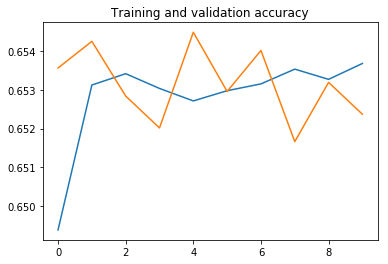

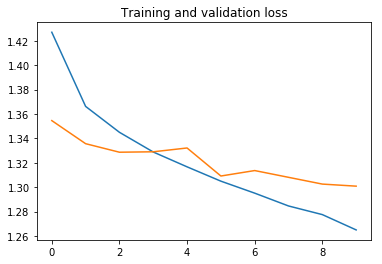

In [9]:
from matplotlib import pyplot

pyplot.plot(history1.history['categorical_accuracy'])
pyplot.plot(history1.history['val_categorical_accuracy'])
pyplot.title('Training and validation accuracy')
pyplot.show()

pyplot.plot(history1.history['loss'])
pyplot.plot(history1.history['val_loss'])
pyplot.title('Training and validation loss')
pyplot.show()

### 7.2) Confusion Matrix (Konfusionsmatrix / Wahrheitsmatrix)
### 7.3) Classification report (Klassifikationsbericht)

In [6]:
#Confution Matrix and Classification Report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, validation_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[   0    0    0    0    4    0    0    0    6    0  393    0    0    0
     0]
 [   0    0    0    0    1    0    0    0    0    0   91    0    0    0
     0]
 [   0    0    0    0    1    0    0    0    2    0  123    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0   62    0    0    0
     0]
 [   0    0    0    0    1    0    0    0    1    0  358    0    0    0
     0]
 [   0    0    0    0    1    0    0    0    2    0   89    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    1    0   72    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0   10    0    0    0
     0]
 [   0    0    0    0    5    0    0    0    5    0  918    0    0    0
     0]
 [   0    0    0    0    1    0    0    0    1    0  206    0    0    0
     0]
 [   0    0    0    0   20    0    0    0   41    0 5538    0    0    0
     1]
 [   0    0    0    0    2    0    0    0    3    0  249    0    0    0
     0]
 [   0    0    0    0  

/home/ente/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## (optional) Export Model + Weights

Run the following cell to export results to disk.

In [ ]:
export_dir= '/home/ente/Dropbox/THESIS/Code/Weights/'
import h5py
model.save_weights(export_dir + 'VGG16_pre_train_weights.h5')

# save as JSON
json_string = model.to_json()

# save as YAML
yaml_string = model.to_yaml()

## 8 Further Improving Accuracy with Fine-Tuning (Feinanpassung)

In our feature-extraction experiment, we only tried adding two classification layers on top of an VGG16 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of VGG16 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `block5` module—i.e., all layers found after `block4`—and recompile the model:

### 8.1 Unfreeze untrainable layers (Untrainierbare Schichten auftauen)

In [13]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from VGG16. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the first convolution blocks, i.e. we will freeze
# the first 15 layers and unfreeze the rest:
for layer in model.layers[:15]:
   layer.trainable = False
for layer in model.layers[15:]:
   layer.trainable = True

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     7

### 8.2 Recompile (Erneut Kompilieren)

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
#metrics= ['categorical_accuracy']
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

### 8.3 Retrain (Ereneut Trainieren)

In [14]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2=model.fit_generator(    
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    class_weight = 'balanced',
    seed=1;
    epochs = 35)

Epoch 1/35
1071/1071 [==============================] - 615s 574ms/step - loss: 1.2614 - categorical_accuracy: 0.6535 - val_loss: 1.2925 - val_categorical_accuracy: 0.6518
Epoch 2/35
1071/1071 [==============================] - 600s 560ms/step - loss: 1.2326 - categorical_accuracy: 0.6556 - val_loss: 1.2936 - val_categorical_accuracy: 0.6465
Epoch 3/35
1071/1071 [==============================] - 610s 570ms/step - loss: 1.2099 - categorical_accuracy: 0.6568 - val_loss: 1.3085 - val_categorical_accuracy: 0.6484
Epoch 4/35
1071/1071 [==============================] - 604s 564ms/step - loss: 1.1842 - categorical_accuracy: 0.6596 - val_loss: 1.2828 - val_categorical_accuracy: 0.6542
Epoch 5/35
1071/1071 [==============================] - 602s 562ms/step - loss: 1.1615 - categorical_accuracy: 0.6618 - val_loss: 1.2892 - val_categorical_accuracy: 0.6479
Epoch 6/35
1071/1071 [==============================] - 602s 562ms/step - loss: 1.1408 - categorical_accuracy: 0.6648 - val_loss: 1.2730 - v

## 9 Evaluate Fine-Tuning
### 9.1) Learning curve (Lernkurve)
### 9.2) Confusion matrix (Wahrheitsmatrix)
### 9.3) Classification report (Klassifikationsbericht)

In [15]:
#Confution Matrix and Classification Report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, validation_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[  17    2    0    0    9    1    2    0    8    1  361    2    0    0
     0]
 [   2    1    0    0    4    0    1    0    3    0   80    0    1    0
     0]
 [   4    1    0    1    5    0    0    0    6    0  108    0    0    0
     1]
 [   1    1    0    0    0    0    1    0    2    0   56    0    1    0
     0]
 [  12    3    0    1   13    0    1    0   23    0  303    1    0    0
     3]
 [   3    1    1    0    2    0    0    0    5    0   80    0    0    0
     0]
 [   1    0    0    0    3    0    0    0    5    0   64    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0   10    0    0    0
     0]
 [  29    1    0    1   35    0    2    0   40    2  810    6    1    0
     1]
 [  13    1    0    0    6    1    0    0    9    2  174    1    0    0
     1]
 [ 198   27    7    4  141    3   18    0  215   11 4935   17   12    0
    12]
 [  12    3    0    0    5    0    1    0   17    0  213    1    0    0
     2]
 [   2    0    0    0  

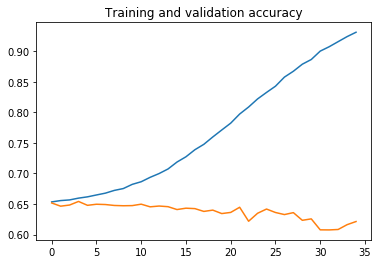

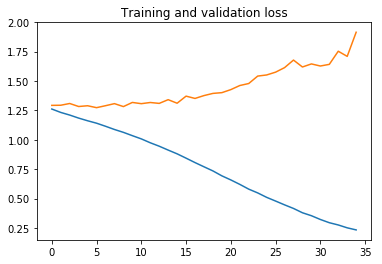

In [16]:
from matplotlib import pyplot

pyplot.plot(history2.history['categorical_accuracy'])
pyplot.plot(history2.history['val_categorical_accuracy'])
pyplot.title('Training and validation accuracy')
pyplot.show()

pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('Training and validation loss')
pyplot.show()

## 10 visualize results (Visualisierung) 

/home/ente/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


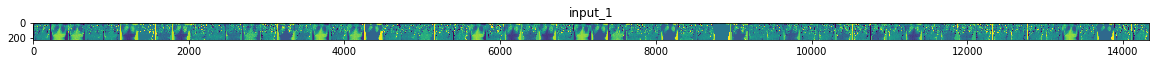

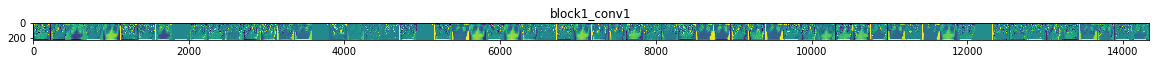

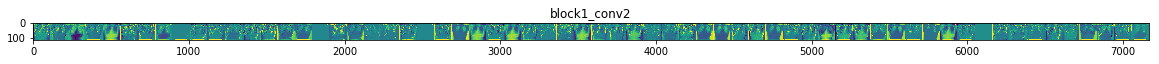

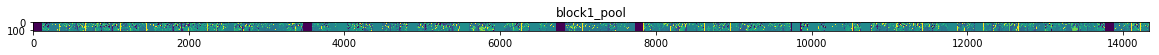

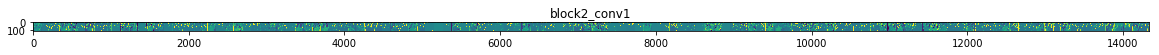

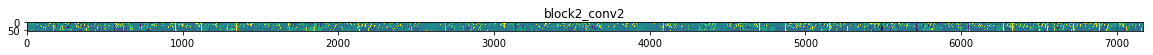

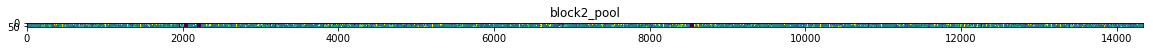

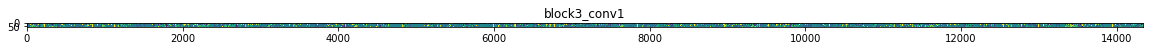

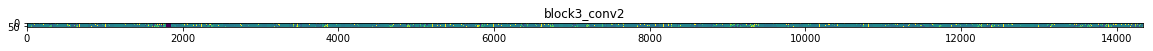

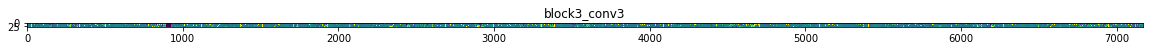

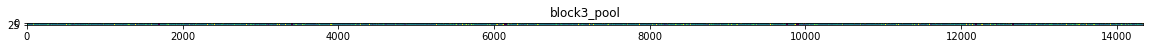

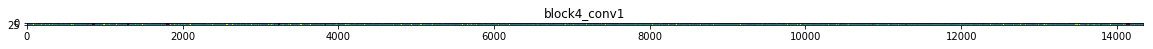

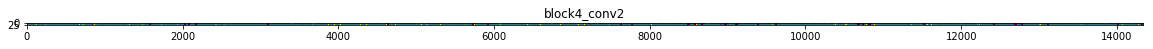

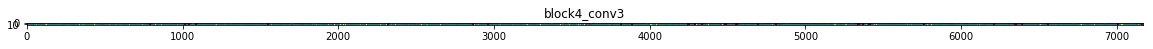

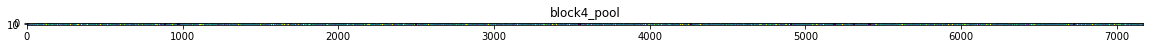

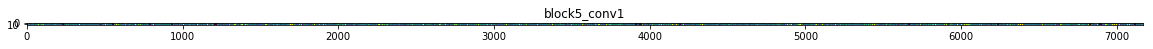

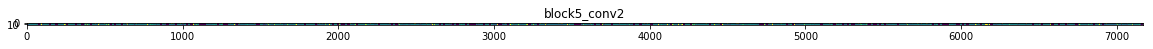

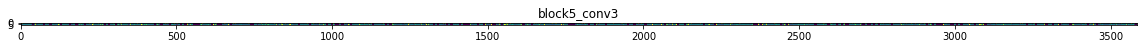

In [17]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(base_model.input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(ate_dir, f) for f in ate_fnames]
dog_img_files = [os.path.join(car_dir, f) for f in car_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=target_size)  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    pyplot.figure(figsize=(scale * n_features, scale))
    pyplot.title(layer_name)
    pyplot.grid(False)
    pyplot.imshow(display_grid, aspect='auto', cmap='viridis')

In [18]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history1.history['categorical_accuracy']
val_acc = history1.history['val_categorical_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.6493930905695612, 0.6531196169524516, 0.6534115792309252, 0.6530320282602083, 0.6527108697591081, 0.6529736358027733, 0.6531488131785587, 0.6535283641405744, 0.653265598081247, 0.6536743452815514]
[0.653558052434457, 0.6542428504733261, 0.6528363807403701, 0.6520159399626795, 0.6544772620721988, 0.6529535865258344, 0.6540084387626773, 0.6516643226062866, 0.653187998096763, 0.6523675574867367]
[1.4269451610291817, 1.3661874301457717, 1.344968447676262, 1.3288224762274239, 1.316669607377568, 1.3049339112294078, 1.295112067530797, 1.284609918388874, 1.2775328050602657, 1.2649864764398862]
[1.3545480919687936, 1.335638533664655, 1.3286470773909722, 1.3290024777840295, 1.3321139951071939, 1.3091551555024588, 1.313618479119295, 1.3080776827580147, 1.302533908903012, 1.3008414678488658]


In [19]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.6534699716866199, 0.6556596887734318, 0.6567399492055245, 0.6596595719798193, 0.6617617003952707, 0.664828431372549, 0.6678053195492333, 0.6723015386455581, 0.6753087501077456, 0.6821698636518757, 0.6864617091454379, 0.6936731774219962, 0.6998335815082309, 0.707337012065003, 0.718635952233231, 0.7272488394464626, 0.7387813494479109, 0.7476278064839214, 0.7596566523657358, 0.7710431812175058, 0.7822253364934869, 0.7971154126973817, 0.8085895302396549, 0.8217862252249223, 0.8324136521544012, 0.8426031356731306, 0.8574640156561391, 0.8670403783831129, 0.8785728883897819, 0.8862514963153784, 0.8999737234036386, 0.9071267992262423, 0.9154185279244517, 0.923651864179148, 0.9308049400087127]
[0.6517815283638069, 0.6465072667324873, 0.6483825598029089, 0.654242850389494, 0.6479137364654434, 0.6496718236945126, 0.6492030005247114, 0.6476793249224588, 0.6472105016688254, 0.64744491321181, 0.6497890294799769, 0.6454524144677003, 0.646741678415192, 0.6456868260665729, 0.6409985935861272, 0.6432